In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
 
from core.pretrained import ASTROMER_v1


%load_ext autoreload
%autoreload 2

### Loading data 

In [3]:
metadata_df = pd.read_csv('./data/raw_data/macho/MACHO_dataset.dat')

In [4]:
metadata_df['Class'].value_counts()

RRL     610
MOA     582
LPV     365
EB      255
Be      128
CEPH    101
QSO      59
Name: Class, dtype: int64

In [5]:
# ds_sample = pd.concat([group.sample(n=200) for lab, group in metadata_df.groupby('Class')])

In [9]:
times      = []
magnitudes = []
labels = []
for index, row in metadata_df.iterrows():
    lc = pd.read_csv('./data/raw_data/macho/LCs/{}'.format(row['Path'].split('/')[-1]))
    lc = lc.sort_values('mjd')
    times.append(lc['mjd'].values)
    magnitudes.append(lc['mag'].values)
    labels.append(row['Class'])

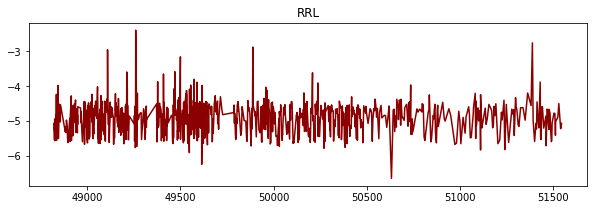

In [10]:
plt.figure(figsize=(10,3))
plt.plot(times[0], magnitudes[0], color='darkred')
plt.title('{}'.format(labels[0]))
plt.show()

### Getting attention vectors from numpy lightcurves

In [11]:
astromer = ASTROMER_v1()

In [13]:
%%time
embs = astromer.encode(times=times, magnitudes=magnitudes, batch_size=2000)

CPU times: user 2min 54s, sys: 1min 36s, total: 4min 31s
Wall time: 58.5 s


### Saving embeddings as tf.records

In [14]:
classes = list(metadata_df['Class'].unique())
labels_code = [classes.index(y) for y in labels]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(embs, labels_code, test_size=0.5, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [16]:
%%time
astromer.to_record(X_train, y_train, dest='./data/records/embeddings/train/css.record')
astromer.to_record(X_val, y_val, dest='./data/records/embeddings/val/css.record')
astromer.to_record(X_test, y_test, dest='./data/records/embeddings/test/css.record')

CPU times: user 1min 46s, sys: 1.19 s, total: 1min 48s
Wall time: 1min 48s


### Training a classifier

In [17]:
cd /tf/astromer

/tf/astromer


In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from core.pretrained import ASTROMER_v1
from core.classifier import get_mlp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
astromer = ASTROMER_v1()

In [30]:
train_batches = astromer.load_record('./data/records/embeddings/train', 
                                     batch_size=64,
                                     max_obs=200,
                                     take=20,
                                     average=True)

val_batches = astromer.load_record('./data/records/embeddings/val', 
                                   batch_size=64,
                                   max_obs=200,
                                   take=5,
                                   average=True)

test_batches = astromer.load_record('./data/records/embeddings/test', 
                                   batch_size=64,
                                   max_obs=200,
                                   take=5,
                                   average=True)

[INFO] Taking 20 balanced batches
[INFO] Taking 5 balanced batches
[INFO] Taking 5 balanced batches


In [31]:
for batch, label in train_batches:
    print(label)
    break

tf.Tensor(
[3 6 0 0 2 2 4 5 6 3 6 6 2 5 6 4 0 6 6 6 0 0 3 0 0 6 1 3 0 6 3 2 0 3 3 0 6
 6 1 3 3 2 5 3 2 6 3 6 3 6 0 6 3 6 6 2 6 0 3 0 5 3 0 0], shape=(64,), dtype=int32)


In [32]:
num_classes = metadata_df['Class'].unique().size
model = get_mlp(num_classes)
model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512     

In [33]:
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss=SparseCategoricalCrossentropy(from_logits=True), 
              metrics='accuracy')

In [34]:
estop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=30, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [35]:
%%time
hist = model.fit(train_batches, 
                 epochs=1000,
                 batch_size=256,
                 validation_data=val_batches,
                 callbacks=[estop])

Epoch 1/1000
17/17 [==============================] - 10s 537ms/step - loss: 1.9234 - accuracy: 0.2457 - val_loss: 1.8795 - val_accuracy: 0.3219
Epoch 2/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.8140 - accuracy: 0.3343 - val_loss: 1.7955 - val_accuracy: 0.3219
Epoch 3/1000
17/17 [==============================] - 0s 11ms/step - loss: 1.7060 - accuracy: 0.3524 - val_loss: 1.7297 - val_accuracy: 0.2500
Epoch 4/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.6077 - accuracy: 0.3581 - val_loss: 1.7208 - val_accuracy: 0.2500
Epoch 5/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.5327 - accuracy: 0.3943 - val_loss: 1.7832 - val_accuracy: 0.2500
Epoch 6/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.4712 - accuracy: 0.4171 - val_loss: 1.9163 - val_accuracy: 0.2500
Epoch 7/1000
17/17 [==============================] - 0s 11ms/step - loss: 1.4185 - accuracy: 0.4419 - val_loss: 2.6849 - val_accuracy: 0.25

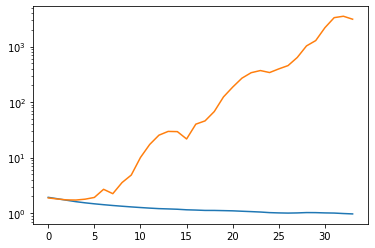

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

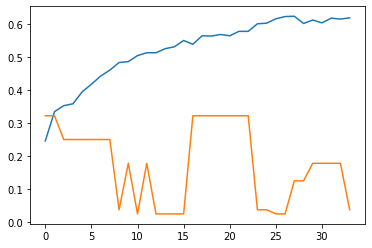

In [37]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [196]:
model.evaluate(test_batches)

5/5 [==============================] - 1s 201ms/step - loss: 2.3987 - accuracy: 0.1125


[2.398744583129883, 0.11249999701976776]